# <center> Generative adversarial network (GAN) </center>
<center><h2> 1.Training Discriminator </h2></center>   
![gan_image1](http://drive.google.com/uc?export=view&id=18HIBQFUXjtWqu364u6i3LFwuZTCt-29w)                      
<br><br>
<center><h2> 2.Training Generator </h2></center>    
![gan_image2](http://drive.google.com/uc?export=view&id=1aHEGLTWmH6iPqk2YUnmNYwFEMBSS7hwp)

------
```
Ref, Deep Learning with Python, 2017, François Chollet
(케라스 창시자에게 배우는 딥러닝, 8장)

코드참고 
https://www.youtube.com/watch?v=T-MCludVNn4
https://github.com/rickiepark/deep-learning-with-python-notebooks/
구글드라이브 이미지 공유방법 http://www.somanet.xyz/2017/06/blog-post_21.html

```


In [1]:
# 아이디어 : 이미지에 선을 딴다, 이미지 증식 

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['all-dogs', 'annotation']


In [3]:
import numpy as np, pandas as pd, os
import xml.etree.ElementTree as ET 
import matplotlib.pyplot as plt, zipfile 
from PIL import Image 

#ROOT = '../input/generative-dog-images/'
ROOT = '../input/'
IMAGES = os.listdir(ROOT + 'all-dogs/all-dogs/')
breeds = os.listdir(ROOT + 'annotation/Annotation/') 
print(len(IMAGES))
print(len(breeds))

20579
120


In [4]:
idxIn = 0
namesIn = []
imagesIn = np.zeros((25000,64,64,3))

In [5]:
# CROP WITH BOUNDING BOXES TO GET DOGS ONLY
# https://www.kaggle.com/paulorzp/show-annotations-and-breeds

for breed in breeds:
    for dog in os.listdir(ROOT+'annotation/Annotation/'+breed):        
        try: 
            img = Image.open(ROOT+'all-dogs/all-dogs/'+dog+'.jpg')            
        except: 
            continue        
        tree = ET.parse(ROOT+'annotation/Annotation/'+breed+'/'+dog)
        root = tree.getroot()
        objects = root.findall('object')
        
        for o in objects:
            bndbox = o.find('bndbox') 
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            w = np.min((xmax - xmin, ymax - ymin))
            img2 = img.crop((xmin, ymin, xmin+w, ymin+w))
            img2 = img2.resize((64,64), Image.ANTIALIAS)
            imagesIn[idxIn,:,:,:] = np.asarray(img2)
            #if idxIn%1000==0: print(idxIn)
            namesIn.append(breed)
            idxIn += 1

# shuffle            
idx = np.arange(idxIn)
np.random.shuffle(idx)
imagesIn = imagesIn[idx,:,:,:]
namesIn = np.array(namesIn)[idx]   

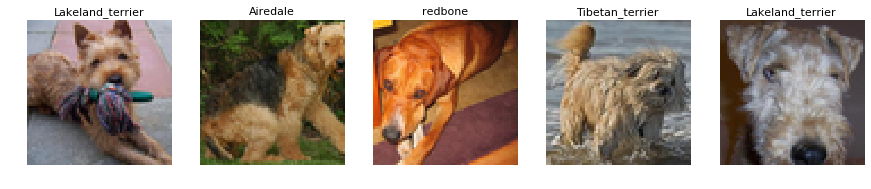

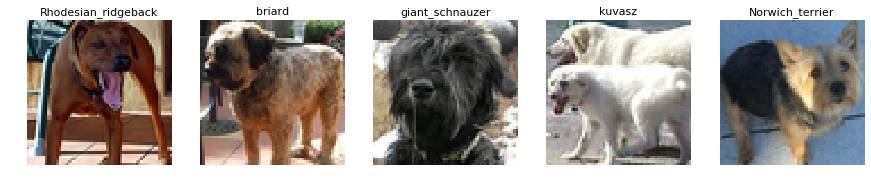

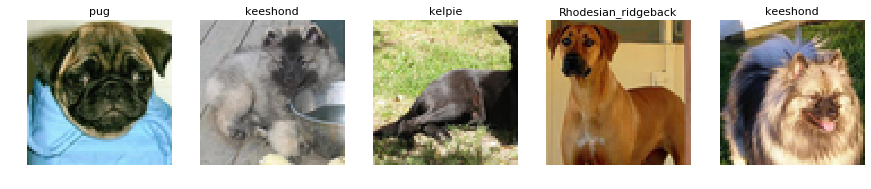

In [6]:
# DISPLAY CROPPED IMAGES

x = np.random.randint(0,idxIn,25)
for k in range(3):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = Image.fromarray( imagesIn[x[k*5+j],:,:,:].astype('uint8') )
        plt.axis('off')
        plt.title(namesIn[x[k*5+j]].split('-')[1],fontsize=11)
        plt.imshow(img)
    plt.show()

In [7]:
print(namesIn.shape)
print(imagesIn.shape)

(22125,)
(22125, 64, 64, 3)


In [8]:
from keras.layers import Input, Reshape, Dropout, Dense, Flatten
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from tqdm import tqdm

from keras.layers import Conv2DTranspose
from keras.layers import ReLU
from keras.initializers import RandomNormal

Using TensorFlow backend.


In [9]:
GENERATE_RES = 2 # (1=32, 2=64, 3=96, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square) #64*64
IMAGE_CHANNELS = 3

# Preview image 
PREVIEW_ROWS = 4
PREVIEW_COLS = 5
PREVIEW_MARGIN = 16
SAVE_FREQ = 100

# Size vector to generate images from
SEED_SIZE = 256 # 100

# Configuration
EPOCHS = 10000
BATCH_SIZE = 64

In [10]:
def build_generator(seed_size, channels):
    
    # Random Normal Weight Initialization
    init = RandomNormal(mean = 0.0, stddev = 0.02)
    
    model = Sequential()

    model.add(Dense(4*4*64,activation="relu",
                    kernel_initializer = init,
                    input_dim=seed_size))
    model.add(Reshape((4,4,64)))

    # For Upsampling, use: PixelShuffle, ConvTranspose2d + stride
    model.add(UpSampling2D()) 
    model.add(Conv2D(128,kernel_size=3,padding="same",
                     kernel_initializer = init))
    model.add(BatchNormalization(momentum=0.8))
    model.add(ReLU())

    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same",
                     kernel_initializer = init))
    model.add(BatchNormalization(momentum=0.8))
    model.add(ReLU())
   
    # Output resolution, additional upsampling
    for i in range(GENERATE_RES):
        model.add(UpSampling2D())
        model.add(Conv2D(128,kernel_size=3,padding="same",
                         kernel_initializer = init))
        model.add(BatchNormalization(momentum=0.8))
        model.add(ReLU())

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=3,padding="same",
                    kernel_initializer = init))
    model.add(Activation("tanh"))

    input = Input(shape=(seed_size,))
    generated_image = model(input)

    return Model(input, generated_image)

In [11]:
def build_discriminator(image_shape):
    
    # Random Normal Weight Initialization
    init = RandomNormal(mean = 0.0, stddev = 0.02)    
    
    model = Sequential()

    model.add(Conv2D(128, kernel_size=3, strides=2, 
                     input_shape=image_shape, padding="same",
                     kernel_initializer = init))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    
    # For Downsampling, use: Average Pooling, Conv2d + stride
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same",
                     kernel_initializer = init)) 
    model.add(ZeroPadding2D(padding=((0,1),(0,1)))) 
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same",
                     kernel_initializer = init))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=3, strides=1, padding="same",
                     kernel_initializer = init))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=3, strides=1, padding="same",
                     kernel_initializer = init))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid',
                    kernel_initializer = init))

    input_image = Input(shape=image_shape)

    validity = model(input_image)

    return Model(input_image, validity)

In [12]:
def save_images(cnt,noise):
    image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)
    
    generated_images = generator.predict(noise)
    #generated_images = 0.5 * generated_images + 0.5
    
    image_count = 0
    for row in range(PREVIEW_ROWS):
        for col in range(PREVIEW_COLS):
            r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
            c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
            image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] = generated_images[image_count] * 255
            image_count += 1
            
    output_path = "./train_ouput" #output
    if not os.path.exists(output_path):
        os.makedirs(output_path)            
    
    filename = os.path.join(output_path,f"train-{cnt}.png")
    im = Image.fromarray(image_array)
    im.save(filename)

    # image view    
    plt.figure(figsize=(10,5))
    plt.axis('off')
    plt.imshow(im)
    plt.show()



- When I started with this competition I followed a lot of the tips and tricks on this site. 
- https://github.com/soumith/ganhacks
- One of the tips is to use BatchNormalization. 
- I however noticed this very nice paper. 
- It discusses the usage and effects of Batch and Weights Normalization in GAN's. 
- After reading it I thought I could give my GAN a try with Weights Normalization.
- https://arxiv.org/pdf/1704.03971.pdf

- I haven't been able to find an official implementation of a Keras Weight Normalization layer. 
- I was however able to find the code at this github repository. F
- from that I will use the class AdamWithWeightnorm.
- https://github.com/krasserm/weightnorm/tree/master/keras_2

In [13]:
# https://www.kaggle.com/rsmits/keras-dcgan-with-weight-normalization

from keras import backend as K
import tensorflow as tf

# adapted from keras.optimizers.Adam
class AdamWithWeightnorm(Adam):
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr
        if self.initial_decay > 0:
            lr *= (1. / (1. + self.decay * K.cast(self.iterations, K.floatx())))

        t = K.cast(self.iterations + 1, K.floatx())
        lr_t = lr * K.sqrt(1. - K.pow(self.beta_2, t)) / (1. - K.pow(self.beta_1, t))

        shapes = [K.get_variable_shape(p) for p in params]
        ms = [K.zeros(shape) for shape in shapes]
        vs = [K.zeros(shape) for shape in shapes]
        self.weights = [self.iterations] + ms + vs

        for p, g, m, v in zip(params, grads, ms, vs):

            # if a weight tensor (len > 1) use weight normalized parameterization
            # this is the only part changed w.r.t. keras.optimizers.Adam
            ps = K.get_variable_shape(p)
            if len(ps)>1:

                # get weight normalization parameters
                V, V_norm, V_scaler, g_param, grad_g, grad_V = get_weightnorm_params_and_grads(p, g)

                # Adam containers for the 'g' parameter
                V_scaler_shape = K.get_variable_shape(V_scaler)
                m_g = K.zeros(V_scaler_shape)
                v_g = K.zeros(V_scaler_shape)

                # update g parameters
                m_g_t = (self.beta_1 * m_g) + (1. - self.beta_1) * grad_g
                v_g_t = (self.beta_2 * v_g) + (1. - self.beta_2) * K.square(grad_g)
                new_g_param = g_param - lr_t * m_g_t / (K.sqrt(v_g_t) + self.epsilon)
                self.updates.append(K.update(m_g, m_g_t))
                self.updates.append(K.update(v_g, v_g_t))

                # update V parameters
                m_t = (self.beta_1 * m) + (1. - self.beta_1) * grad_V
                v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(grad_V)
                new_V_param = V - lr_t * m_t / (K.sqrt(v_t) + self.epsilon)
                self.updates.append(K.update(m, m_t))
                self.updates.append(K.update(v, v_t))

                # if there are constraints we apply them to V, not W
                if getattr(p, 'constraint', None) is not None:
                    new_V_param = p.constraint(new_V_param)

                # wn param updates --> W updates
                add_weightnorm_param_updates(self.updates, new_V_param, new_g_param, p, V_scaler)

            else: # do optimization normally
                m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
                v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)
                p_t = p - lr_t * m_t / (K.sqrt(v_t) + self.epsilon)

                self.updates.append(K.update(m, m_t))
                self.updates.append(K.update(v, v_t))

                new_p = p_t
                # apply constraints
                if getattr(p, 'constraint', None) is not None:
                    new_p = p.constraint(new_p)
                self.updates.append(K.update(p, new_p))
        return self.updates

def get_weightnorm_params_and_grads(p, g):
    ps = K.get_variable_shape(p)

    # construct weight scaler: V_scaler = g/||V||
    V_scaler_shape = (ps[-1],)  # assumes we're using tensorflow!
    V_scaler = K.ones(V_scaler_shape)  # init to ones, so effective parameters don't change

    # get V parameters = ||V||/g * W
    norm_axes = [i for i in range(len(ps) - 1)]
    V = p / tf.reshape(V_scaler, [1] * len(norm_axes) + [-1])

    # split V_scaler into ||V|| and g parameters
    V_norm = tf.sqrt(tf.reduce_sum(tf.square(V), norm_axes))
    g_param = V_scaler * V_norm

    # get grad in V,g parameters
    grad_g = tf.reduce_sum(g * V, norm_axes) / V_norm
    grad_V = tf.reshape(V_scaler, [1] * len(norm_axes) + [-1]) * \
             (g - tf.reshape(grad_g / V_norm, [1] * len(norm_axes) + [-1]) * V)

    return V, V_norm, V_scaler, g_param, grad_g, grad_V

def add_weightnorm_param_updates(updates, new_V_param, new_g_param, W, V_scaler):
    ps = K.get_variable_shape(new_V_param)
    norm_axes = [i for i in range(len(ps) - 1)]

    # update W and V_scaler
    new_V_norm = tf.sqrt(tf.reduce_sum(tf.square(new_V_param), norm_axes))
    new_V_scaler = new_g_param / new_V_norm
    new_W = tf.reshape(new_V_scaler, [1] * len(norm_axes) + [-1]) * new_V_param
    updates.append(K.update(W, new_W))
    updates.append(K.update(V_scaler, new_V_scaler))

# data based initialization for a given Keras model
def data_based_init(model, input):
    # input can be dict, numpy array, or list of numpy arrays
    if type(input) is dict:
        feed_dict = input
    elif type(input) is list:
        feed_dict = {tf_inp: np_inp for tf_inp,np_inp in zip(model.inputs,input)}
    else:
        feed_dict = {model.inputs[0]: input}

    # add learning phase if required
    if model.uses_learning_phase and K.learning_phase() not in feed_dict:
        feed_dict.update({K.learning_phase(): 1})

    # get all layer name, output, weight, bias tuples
    layer_output_weight_bias = []
    for l in model.layers:
        trainable_weights = l.trainable_weights
        if len(trainable_weights) == 2:
            W,b = trainable_weights
            assert(l.built)
            layer_output_weight_bias.append((l.name,l.get_output_at(0),W,b)) # if more than one node, only use the first

    # iterate over our list and do data dependent init
    sess = K.get_session()
    for l,o,W,b in layer_output_weight_bias:
        print('Performing data dependent initialization for layer ' + l)
        m,v = tf.nn.moments(o, [i for i in range(len(o.get_shape())-1)])
        s = tf.sqrt(v + 1e-10)
        updates = tf.group(W.assign(W/tf.reshape(s,[1]*(len(W.get_shape())-1)+[-1])), b.assign((b-m)/s))
        sess.run(updates, feed_dict)

In [14]:
# 판별자 학습모델
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)
#optimizer = Adam(1.5e-4,0.5) # learning rate and momentum adjusted from paper

discriminator = build_discriminator(image_shape)
#discriminator.compile(loss="binary_crossentropy",optimizer=optimizer) # metrics=["accuracy"])
discriminator.compile(loss = 'binary_crossentropy', optimizer = AdamWithWeightnorm(lr = 0.0002, beta_1 = 0.5))
generator = build_generator(SEED_SIZE,IMAGE_CHANNELS)

# 생성자 학습모델 # 학습속도가 느림, 판별자와 학습률 구분설정
random_input = Input(shape=(SEED_SIZE,))

generated_image = generator(random_input)

discriminator.trainable = False

validity = discriminator(generated_image)

combined = Model(random_input,validity)
#combined.compile(loss="binary_crossentropy",optimizer=optimizer) # metrics=["accuracy"])
combined.compile(loss = 'binary_crossentropy', optimizer = AdamWithWeightnorm(lr = 0.0002, beta_1 = 0.5))

In [15]:
import os
from keras.preprocessing import image

x_train= imagesIn
print(x_train.shape)

# 데이터를 정규화합니다.(minmax scale 
x_train = x_train.reshape((x_train.shape[0],) + (64, 64, 3)).astype('float32') / 255
print(x_train.shape)

# [-1,1]로 정규화
#all_images[index,:] = (image.astype(np.float32) - 127.5)/127.5


(22125, 64, 64, 3)
(22125, 64, 64, 3)


In [16]:
y_real = np.ones((BATCH_SIZE,1))  # 레이블 1 진짜
y_fake = np.zeros((BATCH_SIZE,1)) # 레이블 0 가짜


fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, SEED_SIZE))

cnt = 1
EPOCHS = 90000

for epoch in range(EPOCHS):
    idx = np.random.randint(0,x_train.shape[0],BATCH_SIZE)
    x_real = x_train[idx]

    # Generate some images
    seed = np.random.normal(0,1,(BATCH_SIZE,SEED_SIZE))
    x_fake = generator.predict(seed)
    
    # 레이블에 노이즈를 넣는다.
    y_real_noise = np.ones((BATCH_SIZE,1)) - 0.1 #- 0.05 * np.random.random(y_real.shape)
    y_fake_noise = np.zeros((BATCH_SIZE,1)) + 0.01 # + 0.05 * np.random.random(y_real.shape)
    
    # Train discriminator on real and fake
    discriminator_metric_real = discriminator.train_on_batch(x_real,y_real_noise)
    discriminator_metric_generated = discriminator.train_on_batch(x_fake,y_fake_noise)
    discriminator_metric = 0.5 * np.add(discriminator_metric_real,discriminator_metric_generated)
    
    # Train generator on Calculate losses
    generator_metric = combined.train_on_batch(seed,y_real_noise)
    
    # Time for an update?
    if epoch % SAVE_FREQ == 0:
        #save_images(cnt, fixed_seed)
        cnt += 1
        print("Epoch {0}, Discriminator : {1:.3f}, Generator : {2:.3f}".format(epoch, discriminator_metric, generator_metric))
        


/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 0, Discriminator : 1.804, Generator : 1.326


/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 100, Discriminator : 0.610, Generator : 2.828
Epoch 200, Discriminator : 0.496, Generator : 0.804
Epoch 300, Discriminator : 0.295, Generator : 3.100
Epoch 400, Discriminator : 0.880, Generator : 0.861
Epoch 500, Discriminator : 0.634, Generator : 1.429
Epoch 600, Discriminator : 0.690, Generator : 1.257
Epoch 700, Discriminator : 1.040, Generator : 1.829
Epoch 800, Discriminator : 0.617, Generator : 1.281
Epoch 900, Discriminator : 0.467, Generator : 1.386
Epoch 1000, Discriminator : 0.712, Generator : 1.168
Epoch 1100, Discriminator : 0.569, Generator : 1.215
Epoch 1200, Discriminator : 0.398, Generator : 1.488
Epoch 1300, Discriminator : 0.457, Generator : 2.016
Epoch 1400, Discriminator : 0.542, Generator : 1.246
Epoch 1500, Discriminator : 0.521, Generator : 1.576
Epoch 1600, Discriminator : 0.557, Generator : 2.388
Epoch 1700, Discriminator : 0.879, Generator : 2.184
Epoch 1800, Discriminator : 0.525, Generator : 1.525
Epoch 1900, Discriminator : 0.630, Generator : 0.584
Ep

In [17]:
#generator.save("./dog_generator.h5")
# <a href="dog_generator.h5"> Download file </a> <br>

In [18]:
# import os
# import zipfile
 
# fantasy_zip = zipfile.ZipFile('./archive.zip', 'w')
 
# for folder, subfolders, files in os.walk('./train_ouput'):
 
#     for file in files:
#         if file.endswith('.png'):
#             fantasy_zip.write(os.path.join(folder, file), file, compress_type = zipfile.ZIP_DEFLATED)

# fantasy_zip.close()

<a href="archive.zip"> Download file </a> <br>

In [19]:
import os
import zipfile

# SAVE TO ZIP FILE NAMED IMAGES.ZIP
z = zipfile.PyZipFile('images.zip', mode='w')
k= 0

for i_batch in range(0,10000, BATCH_SIZE):
    noise = np.random.normal(0,1,(BATCH_SIZE,SEED_SIZE))    
    gen_img = generator.predict(noise)
    for i in range(BATCH_SIZE):
        img = Image.fromarray((255*gen_img[i]).astype('uint8'))    
        # SAVE TO ZIP FILE  
        f = str(k)+'.png'
        img.save(f,'PNG'); z.write(f); os.remove(f)
        k+=1
        if k == 10000:
            break
z.close()

<a href="images.zip"> Download file </a> <br>

# LB SCORE 측정하기

    - 커널에서 Add Dataset클릭 -> mifid검색 -> Dog face generation competition MiFID metric input 추가 -> Workspace의 input폴더에 데이타셋 추가되었음.
    - 처음 dog image파일 불러올때 ROOT수정, ROOT = '../input/generative-dog-images/'
    - 캐글제출시에는 해당 데이터셋 삭제 후 커밋필요
    - 해당 데이터셋이 없을때는 다시 ROOT = '../input/' 으로 수정
